In [ ]:
%pip install langchain_openai

In [1]:
from typing_extensions import Literal
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, StateGraph,START,END
from langgraph.types import Command
from dotenv import load_dotenv
from IPython.display import Image, display
# from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from typing import Annotated
from langchain_experimental.utilities import PythonREPL

In [2]:
import os

In [3]:
load_dotenv()

True

In [4]:
groq_model=ChatGroq(model="deepseek-r1-distill-llama-70b")

In [ ]:
# groq_model.invoke("Hell Yeah!")

"<think>\n\n</think>\n\nHell yeah! What's got you pumped up? 😎"

In [160]:
def add_numbers(a: int, b: int) -> int:
    """"use this function to add two numbers"""
    return a + b

In [161]:
@tool 
def transfer_to_addition_expert():
    """Ask the addition expert for help to add two numbers."""
    return 

In [162]:
@tool
def transfer_to_multiplication_expert():
    """Ask the multiplication expert for help to multiply two numbers."""
    pass

In [207]:
def addition_expert(state: MessagesState)-> Command[Literal["multiplication_expert",END]]:
    print("----Addition Expert----")
    system_message=(
         "You are an addition expert, you can ask the multiplication expert for help with multiplication.  you can also call function add_numbers(a,b) to multiply two numbers."
        "Always do your portion of calculation before the handoff."
        )
    messages=[{"role":"system","content":system_message}]+ [state["messages"][-1].content]
    print("from add",state["messages"][-1].content)

    ai_msg= groq_model.bind_tools([transfer_to_multiplication_expert]).invoke(messages)
    print("to add",ai_msg)
    if len(ai_msg.tool_calls)>0:
        tool_call_id=ai_msg.tool_calls[-1]["id"]
        tool_msg={
            "role":"tool",
            "content":"Successfully Transferred ",
            "tool_call_id":tool_call_id
        }
        return Command(
            goto="multiplication_expert",update= {"messages":[tool_msg,ai_msg]}
                       )
    return {"messages":[ai_msg]}

In [208]:
def multiplication_expert(state: MessagesState)-> Command[Literal["addition_expert",END]]:
    print("----MULTIPLICATION EXPERT----")
    system_message=(
        "You are a multiplication expert, you can ask the addition expert for help with addition. you can also call function multiply_numbers(a,b) to multiply two numbers."
        "Always do your portion of calculation before the handoff."
    )
    messages=[{"role":"system","content":system_message}]+ [state["messages"][-1].content
    ]
    print("from mul",state["messages"][-1].content)
    ai_msg= groq_model.bind_tools([transfer_to_addition_expert]).invoke(messages)
    print("to mul",ai_msg)
    if len(ai_msg.tool_calls)>0:
        tool_call_id=ai_msg.tool_calls[-1]["id"]
        tool_msg={
            "role":"tool",
            "content":"Successfully Transferred ",
            "tool_call_id":tool_call_id
        }
        return Command(
            goto="addition_expert",update= {"messages":[tool_msg,ai_msg]}
                       )
    return {"messages":[ai_msg]}

In [209]:
graph=StateGraph(MessagesState)

graph.add_node("addition_expert", addition_expert)
graph.add_node("multiplication_expert", multiplication_expert)

graph.add_edge(START,"addition_expert")
# graph.add_edge("addition_expert","multiplication_expert")
# graph.add_edge("multiplication_expert",END)


In [210]:
app = graph.compile()

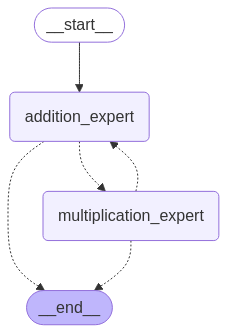

In [211]:
from IPython.display import Image, display
try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [213]:
res=app.invoke({"messages":[("user","what's (3 + 5) * 12. Provide me the output")]})
print(res["messages"][-1].content)

----Addition Expert----
from add what's (3 + 5) * 12. Provide me the output
to add content='' additional_kwargs={'tool_calls': [{'id': 'call_tbkr', 'function': {'arguments': '{"a":8,"b":12}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 206, 'prompt_tokens': 180, 'total_tokens': 386, 'completion_time': 0.749090909, 'prompt_time': 0.010446182, 'queue_time': 0.047491058, 'total_time': 0.759537091}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_454c494f52', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-351306d2-fd0d-4c07-994e-6dc3e8e08adc-0' tool_calls=[{'name': 'transfer_to_multiplication_expert', 'args': {'a': 8, 'b': 12}, 'id': 'call_tbkr', 'type': 'tool_call'}] usage_metadata={'input_tokens': 180, 'output_tokens': 206, 'total_tokens': 386}
----MULTIPLICATION EXPERT----
from mul 
to mul content='' additional_kwargs={'tool_calls': [{'id': 'call_76gb', 'function': {'argume